# Read Data

In [0]:
import numpy as np
import keras
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam

In [0]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import os

In [0]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
x_train_path = '/content/drive/My Drive/Colab Notebooks/Training/original_retinal_images/'
y_train_path = '/content/drive/My Drive/Colab Notebooks/Training/blood_vessel_segmentation_masks/'
x_test_path = '/content/drive/My Drive/Colab Notebooks/Test/original_retinal_images/'
y_test_path = '/content/drive/My Drive/Colab Notebooks/Test/blood_vessel_segmentation_masks/'

In [0]:
def read_data(path):
    image_names = sorted(os.listdir(path))
    l = []
    for i in range(len(image_names)):
        tmp = cv2.imread(path + image_names[i], 0)
        l.append(tmp)

    return np.asanyarray(l)

In [0]:
x_train = read_data(x_train_path)
y_train = read_data(y_train_path)
x_test = read_data(x_test_path) /255
y_test = read_data(y_test_path) /255

x_train = np.expand_dims(x_train, axis=3)
y_train = np.expand_dims(y_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=3)

In [0]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(20, 512, 512, 1) (20, 512, 512, 1) (20, 512, 512, 1) (20, 512, 512, 1)


In [0]:
'''
for i in range(len(x_train)):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(x_test[i].reshape((512,512)), cmap = 'gray')
    f.add_subplot(1,2, 2)
    plt.imshow(y_test[i].reshape((512,512)), cmap = 'gray')
    plt.show(block=True)
'''

"\nfor i in range(len(x_train)):\n    f = plt.figure()\n    f.add_subplot(1,2, 1)\n    plt.imshow(x_test[i].reshape((512,512)), cmap = 'gray')\n    f.add_subplot(1,2, 2)\n    plt.imshow(y_test[i].reshape((512,512)), cmap = 'gray')\n    plt.show(block=True)\n"

In [0]:
def unet(input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format='channels_last')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv11 = keras.layers.Softmax()(conv10)
    model = Model(input = inputs, output = conv10)

    def dice_coefficient(target, pred):
        target = K.flatten(target)
        pred = K.flatten(pred)
        intersection = K.sum(pred * target)
        return (2. * intersection + 1.) / (K.sum(target) + K.sum(pred) + 1.)

    def dice_coef_loss(target, pred):
        return 1-dice_coefficient(target, pred)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy', dice_coefficient])
    return model

In [0]:
model = unet()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
def gene():

    data_gen_args = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        rescale=1./255,
                        fill_mode='nearest')

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed = 1
    #image_datagen.fit(images, augment=True, seed=seed)
    #mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/Training/',classes = ['original_retinal_images'],
        class_mode=None, color_mode = "grayscale", target_size = (512,512), batch_size = 5,
        seed=seed)

    mask_generator = mask_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/Training/',classes = ['blood_vessel_segmentation_masks'],
        class_mode=None, color_mode = "grayscale", target_size = (512,512), batch_size = 5,
        seed=seed)

    train_generator = zip(image_generator, mask_generator)

    '''
    n = 1
    
    for i,j in train_generator:
        #print("n = ", n)
        n += 1
        f = plt.figure(figsize=(4, 4))
        f.add_subplot(121)
        plt.imshow(i[0].reshape((512,512)), cmap = 'gray')
        plt.axis('off')
        f.add_subplot(122)
        plt.imshow(j[0].reshape((512,512)), cmap = 'gray')
        plt.axis('off')

        plt.show(block=True)
        #print(i[0].max(),j[0].max())
    '''

    return train_generator

In [0]:
myGene = gene()

Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


In [0]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/model_infinity.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [0]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/model_infinity.hdf5')

In [0]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=1000,callbacks=[model_checkpoint], validation_data = (x_test, y_test))



Epoch 1/1
10/10 [==============================] - 19s 2s/step - loss: 0.0734 - acc: 0.8703 - dice_coefficient: 0.7209 - val_loss: 0.1365 - val_acc: 0.9193 - val_dice_coefficient: 0.7255

Epoch 00001: loss improved from inf to 0.07341, saving model to /content/drive/My Drive/Colab Notebooks/model_infinity.hdf5


In [0]:
tmp = model.predict(x_train[3].reshape((1,512,512,1)))

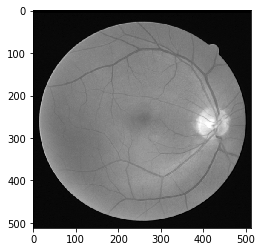

In [0]:
plt.imshow(x_train[3].reshape((512,512)), cmap = 'gray')

In [0]:
#plt.imsave('tmp.png', tmp[0].reshape((512,512)), cmap = 'gray', vmin=0,vmax=1,)

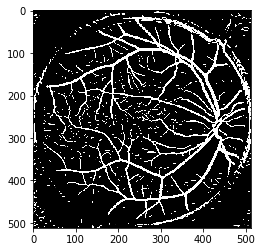

In [0]:
plt.imshow(tmp[0].reshape((512,512)), cmap = 'gray', vmin=0,vmax=1)